In [1]:
import glob
import os
import json
import mmcv
import numpy as np

In [22]:
path='/data2/rice2/'

In [45]:
annotations=[]
for root, dirs, files in os.walk(path): 
    for f in files: 
        if f[-4:]=='json':
            jsonfile=mmcv.load(os.path.join(root,f))
            for ann in jsonfile['images']:
                imagename=os.path.join(root,ann['image'])
                if os.path.exists(imagename):
                    bboxes=[]
                    for bbox in ann['annotations'][1]['annotations']:
                        tembbox=[int(bbox['annotation']['minX']),int(bbox['annotation']['minY']),int(bbox['annotation']['maxX']),int(bbox['annotation']['maxY'])]
                        tembbox=np.asarray(tembbox)
                        tembbox[tembbox<0]=0
                        tembbox=tembbox.tolist()
                        bboxes.append(tembbox)
                    bboxes = np.array(bboxes, ndmin=2) - 1  
                    bboxes_ignore = np.zeros((0, 4))
                    labels=np.ones((bboxes.shape[0]))
                    temimage=mmcv.imread(imagename)
                
                    oneimg={'filename':imagename[13:],
                        'width': temimage.shape[1],
                        'height': temimage.shape[0],
                        'ann': {
                            'bboxes': bboxes.astype(np.float32),
                            'labels': labels.astype(np.int64),
                            'bboxes_ignore':bboxes_ignore.astype(np.float32)}
                       }
                    if(oneimg['ann']['bboxes'].shape[1]==4):
                        annotations.append(oneimg)

In [35]:
import pandas as pd

In [46]:
annotationspd=pd.DataFrame(annotations)

In [48]:
annotationspd.head()

,ann,filename,height,width
0,"{'bboxes': [[1710.0, 931.0, 1764.0, 981.0], [1...",DJI_0165/0_2053.png,1025,1823
1,"{'bboxes': [[1719.0, 979.0, 1774.0, 1026.0], [...",DJI_0165/1823_0.png,1025,1823
2,"{'bboxes': [[135.0, 346.0, 191.0, 398.0], [167...",DJI_0165/1823_2053.png,1025,1823
3,"{'bboxes': [[1635.0, 87.0, 1692.0, 126.0], [15...",DJI_0165/3646_0.png,1025,1823
4,"{'bboxes': [[165.0, 336.0, 215.0, 397.0], [112...",DJI_0165/3646_2053.png,1025,1823


In [56]:
mmcv.dump(annotations, '/data2/rice2/annotations.pkl')

In [57]:
cfg = mmcv.Config.fromfile('configs/faster_rcnn_r50_fpn_2x-rice.py')

In [58]:
cfg.data.train

{'type': 'CustomDataset',
 'ann_file': '/data2/rice2/annotations.pkl',
 'img_prefix': '/data2/rice2/',
 'img_scale': (1333, 800),
 'img_norm_cfg': {'mean': [123.675, 116.28, 103.53],
  'std': [58.395, 57.12, 57.375],
  'to_rgb': True},
 'size_divisor': 32,
 'flip_ratio': 0.5,
 'with_mask': False,
 'with_crowd': True,
 'with_label': True}

In [5]:
from mmdet import datasets
from mmcv.runner import obj_from_dict

In [6]:
train_dataset = obj_from_dict(cfg.data.train, datasets)

# 预测

In [3]:
from mmcv.runner import load_checkpoint
from mmdet.models import build_detector
from mmdet.apis import inference_detector, show_result
from mmdet.datasets import to_tensor
from mmdet.datasets.transforms import ImageTransform
from mmdet.core import get_classes
cfg = mmcv.Config.fromfile('configs/faster_rcnn_r50_fpn_2x-rice.py')
cfg.model.pretrained = None

# construct the model and load checkpoint
model = build_detector(cfg.model, test_cfg=cfg.test_cfg)
_ = load_checkpoint(model, '/data2/rice2/log/latest.pth')

In [16]:
score_thr=0.3
bbox_color='green'
text_color='green'
thickness=1
font_scale=0.5
show=True
win_name=''
wait_time=0
out_file=None
class_names=['rice']

In [19]:
img = mmcv.imread('/data2/rice2/DJI_0162/3646_2053.png')
result = inference_detector(model, img, cfg)

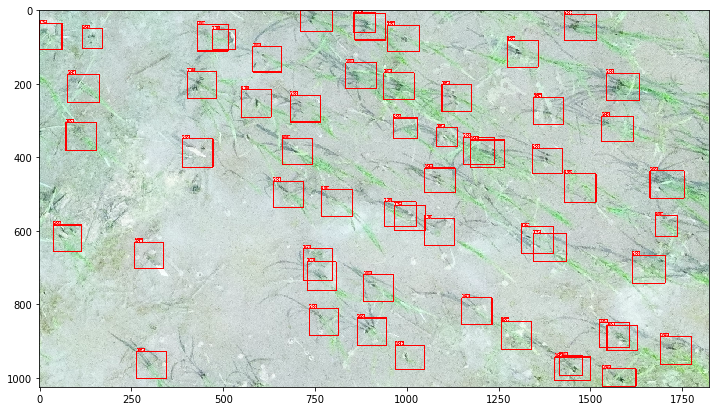

In [20]:
bboxes = np.vstack(result)
newboxes=[]
for i in range(bboxes.shape[0]):
    if(bboxes[i,-1]>score_thr):
        newboxes.append(bboxes[i,:4].astype(np.int32))
newboxes=np.asarray(newboxes)
ids=np.ones((newboxes.shape[0]),dtype='uint8')
annotations = {'image': img, 'bboxes': newboxes, 'category_id': ids}
category_id_to_name = {1: 'rice'}
visualize(annotations, category_id_to_name)

In [11]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

import matplotlib.pyplot as plt
import cv2
%matplotlib inline
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(bbox[0]), int(bbox[2]), int(bbox[1]), int(bbox[3])
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [85]:
img=mmcv.imread(annotations.iloc[1,1])
newboxes=annotations.iloc[1,0]
ids=np.ones((newboxes.shape[0]))

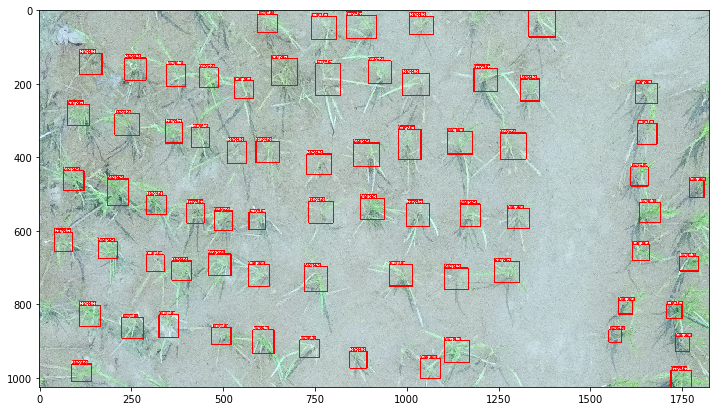

In [86]:
show = {'image': img, 'bboxes': newboxes, 'category_id': ids}
category_id_to_name = {1: 'fengche'}
visualize(show, category_id_to_name)